In [1]:
# Importing libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import FileLink
import shap
import seaborn as sns
from sklearn.linear_model import LinearRegression
from itertools import combinations

# Importing Keras libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
#Importing data
data = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',') # Air Quality


# **Air Quality**

## Preprocessing

In [3]:
#Cleaning up header names so they are more readable
new_col_names = ['Date', 'Time', 'CO (mg/m^3), True HA', 'Tin oxide, HA', 'NMHC, True HA', 'Benzene (micromg/m^3), True HA', 'Titania, HA', 'NOx (ppb), True HA', 'Tungsten oxide, HA, nom NOx targeted','NO2 (micromg/m^3), True HA' ,'Tungsten oxide, HA, nom NO2 targeted','Indium oxide, HA', 'Temp, Celsius', 'Relative Humidity, %', 'Absolute Humidity']
data.columns = new_col_names

#In the dataset notes, missing data has been replaced with -200
#Let's remove those data points
for col in new_col_names:
    data = data[data[col] != -200]

#Sectioning out data of interest
interest_cols = ['Tin oxide, HA', 'NOx (ppb), True HA','CO (mg/m^3), True HA', 'NO2 (micromg/m^3), True HA', 'Temp, Celsius', 'Relative Humidity, %', 'Absolute Humidity']
interest_data = data[interest_cols]

#Normalizing the data from [0,1]
min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(interest_data)
df_normalized = pd.DataFrame(np_scaled, columns = interest_cols)

def create_sequences(data, input_sequence_length, output_sequence_length, input_cols, output_cols):
    inputs = []
    outputs = []

    for i in range(len(data) - input_sequence_length - output_sequence_length + 1):
        input_data = data[input_cols].iloc[i:(i + input_sequence_length)].values
        output_data = data[output_cols].iloc[(i + input_sequence_length):(i + input_sequence_length + output_sequence_length)].values
        inputs.append(input_data)
        outputs.append(output_data)
        
    return np.array(inputs), np.array(outputs)

# Define the columns you need for input and output
input_cols = ['Tin oxide, HA', 'NOx (ppb), True HA', 'CO (mg/m^3), True HA', 'NO2 (micromg/m^3), True HA', 'Temp, Celsius', 'Relative Humidity, %', 'Absolute Humidity']
output_col = ['CO (mg/m^3), True HA']

input_sequence_length = 100  # Number of time steps for input
output_sequence_length = 12  # Number of time steps to predict

# Create sequences with the specified columns for input and output
x, y = create_sequences(df_normalized, input_sequence_length, output_sequence_length, input_cols, output_col)

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)


## LSTM

### *Model training*

2024-08-14 10:04:29.168036: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


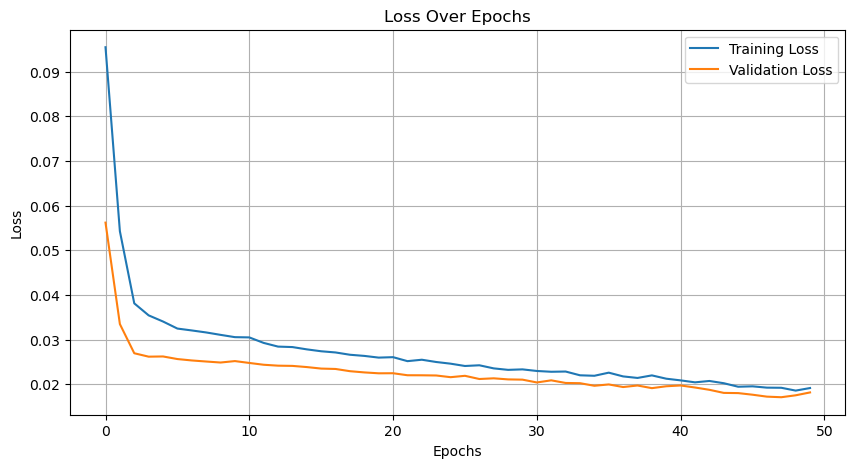

In [4]:
modelAQ = Sequential([
    LSTM(50, activation='relu', input_shape=(input_sequence_length, train_x.shape[2])),
    Dropout(0.2),
    Dense(output_sequence_length * train_y.shape[2]),  # This layer will output a flattened array
])
modelAQ.compile(optimizer='adam', loss='mse')

history = modelAQ.fit(train_x, train_y, epochs=50, validation_split=0.1, verbose=0)

predictions = modelAQ.predict(test_x, verbose=0)
# Evaluate the model
test_loss = modelAQ.evaluate(test_x, test_y, verbose=0)

# Flatten the predictions and actuals for MSE calculation
predicted_flattened = modelAQ.predict(test_x, verbose=0).reshape(-1)
actual_flattened = test_y.reshape(-1)

#mse_value = mean_squared_error(actual_flattened, predicted_flattened)
#print(f"Mean Squared Error on Test Set: {mse_value}")

def plot_training_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_loss(history)


## Surrogate model

### *Preprocessing & model training*

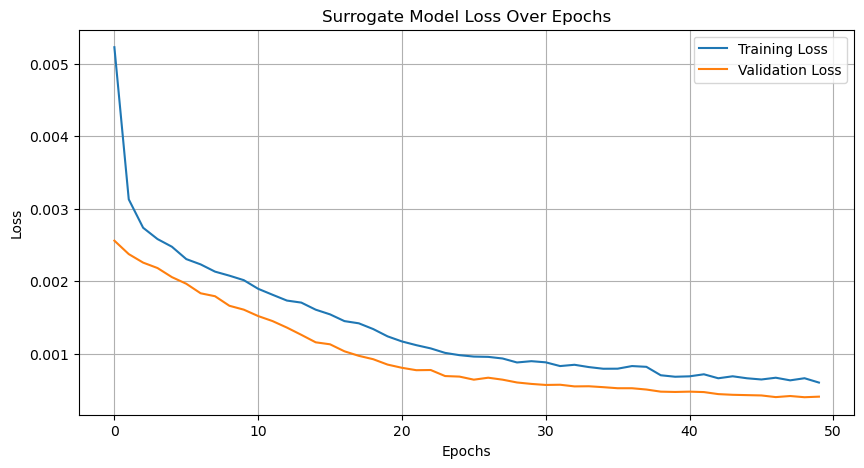

In [6]:
# Function to calculate differences including the last input time step
def calculate_differences_with_last_input(data, last_input):
    first_diff = data[:, 0] - last_input
    subsequent_diffs = np.diff(data, axis=1)
    diffs_with_last_input = np.hstack([first_diff[:, np.newaxis], subsequent_diffs])
    return diffs_with_last_input

# Function to prepare the training data with differences
def prepare_differenced_data_with_last_input(input_data, model):
    predictions = model.predict(input_data, verbose=0)
    last_input_steps = input_data[:, -1, co_index]  # Assuming the first feature of the last input step
    differenced_predictions = calculate_differences_with_last_input(predictions, last_input_steps)
    return differenced_predictions

# Prepare differenced training and testing data
train_y_diff = prepare_differenced_data_with_last_input(train_x, modelAQ)
test_y_diff = prepare_differenced_data_with_last_input(test_x, modelAQ)

# Reshape the differenced data to add the last dimension
train_y_diff = train_y_diff.reshape((train_y_diff.shape[0], train_y_diff.shape[1], 1))
test_y_diff = test_y_diff.reshape((test_y_diff.shape[0], test_y_diff.shape[1], 1))

# Define the surrogate model
model_surrogate = Sequential([
    LSTM(50, activation='relu', input_shape=(input_sequence_length, train_x.shape[2])),
    Dropout(0.2),
    Dense(output_sequence_length * train_y_diff.shape[2]),  # This layer will output a flattened array
    Reshape((output_sequence_length, train_y_diff.shape[2]))  # Reshape to match the original dimensions
])
model_surrogate.compile(optimizer='adam', loss='mse')

# Train the surrogate model on the differenced data
history_surrogate = model_surrogate.fit(train_x, train_y_diff, epochs=50, validation_split=0.1, verbose=0)

# Plotting the training history
def plot_training_loss(history, title='Loss Over Epochs'):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_loss(history_surrogate, title='Surrogate Model Loss Over Epochs')


### *Plot*

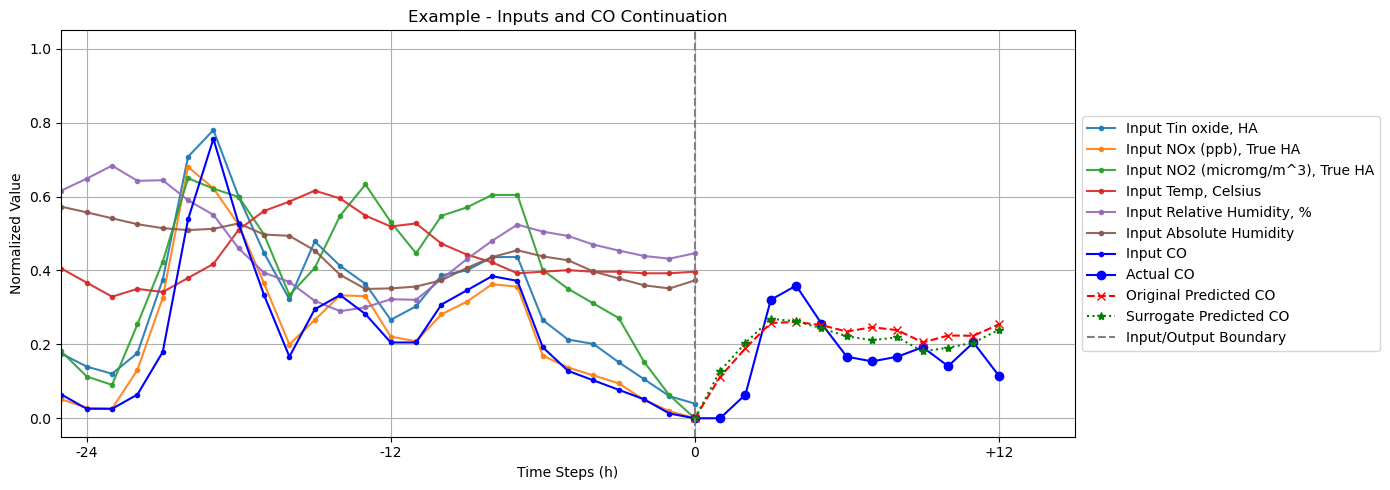

In [500]:
# Make predictions with the surrogate model
predictions_surrogate = model_surrogate.predict(test_x, verbose=0)

# Function to revert the differenced data to original data using the last step of input data
def revert_differences(differenced_data, original_input):
    reverted_data = []
    for i in range(differenced_data.shape[0]):
        last_input_step = original_input[i, -1, co_index]  # Assuming the first feature of the last input step
        reverted_sequence = np.cumsum(np.insert(differenced_data[i].flatten(), 0, last_input_step))
        reverted_data.append(reverted_sequence[1:])  # Exclude the inserted last input step
    return np.array(reverted_data)

# Revert the predictions to the original scale
predictions_surrogate_reverted = revert_differences(predictions_surrogate, test_x)

# Select one example for detailed output
example_index = np.random.randint(test_x.shape[0])
actual_input_co = test_x[example_index][:, co_index]
actual_output = test_y[example_index]
predicted_og = modelAQ.predict(test_x[[example_index]], verbose=0).flatten()
predicted_diff = test_y_diff[example_index].flatten()
predicted_surrogate = predictions_surrogate_reverted[example_index]

# Function to plot the results
def plot_example(inputs, actual_output, predicted_og, predicted_surrogate, feature_name, all_features):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
        
        input_time_steps = np.arange(-inputs.shape[0] + 1, 1)
        future_time_steps = np.arange(1, actual_output.shape[0] + 1)

        plt.figure(figsize=(14, 5))

        # Plot all input features with transparency
        for j in range(inputs.shape[1]):
            if all_features[j] != feature_name:
                plt.plot(input_time_steps, inputs[:, j], label=f'Input {all_features[j]}', alpha=0.9, marker='.')
        
        # Plot the input CO feature with specific style
        plt.plot(input_time_steps, inputs[:, all_features.index(feature_name)], label='Input CO', color='blue', marker='.')

        # Plot the last point of input CO to ensure visual continuity
        last_input_value = inputs[-1, all_features.index(feature_name)]

        # Plot actual CO from the last input CO point
        plt.plot([0] + list(future_time_steps), [last_input_value] + list(actual_output), label='Actual CO', color='blue', marker='o')

        # Plot original predicted CO from the last input CO point
        plt.plot([0] + list(future_time_steps), [last_input_value] + list(predicted_og), label='Original Predicted CO', color='red', linestyle='--', marker='x')

        # Plot surrogate predicted CO from the last input CO point
        plt.plot([0] + list(future_time_steps), [last_input_value] + list(predicted_surrogate), label='Surrogate Predicted CO', color='green', linestyle=':', marker='*')

        # Draw a vertical line to indicate the transition from input to output
        plt.axvline(x=0, color='grey', linestyle='--', label='Input/Output Boundary')

        plt.title('Example - Inputs and CO Continuation')
        plt.xlabel('Time Steps (h)')
        plt.ylabel('Normalized Value')

        # Set ticks every 12 hours, ensuring they go through zero
        max_time_steps = max(inputs.shape[0], actual_output.shape[0])
        all_ticks = np.arange(-((inputs.shape[0] // 12) * 12), (actual_output.shape[0] + 12), 12)
        plt.xticks(all_ticks)

        # Customizing tick labels to include explicit '+' for positive values, excluding zero
        tick_labels = [f'{tick:+d}' if tick != 0 else '0' for tick in all_ticks]
        plt.gca().set_xticklabels(tick_labels)

        # Setting y-axis limits from -0.05 to 1.05
        plt.ylim(-0.05, 1.05)
        plt.xlim(-25,15)

        # Moving the legend outside of the plot to the right
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        plt.grid(True)
        plt.tight_layout()  # Adjust layout to make room for the legend
        plt.show()

plot_example(test_x[example_index], actual_output, predicted_og, predicted_surrogate, 'CO (mg/m^3), True HA', interest_cols)


## SHAP values

### *Calculation (don't run again)*

In [8]:
# Custom wrapper for the LSTM model to handle flattened input
class WrappedModel:
    def __init__(self, model, input_shape):
        self.model = model
        self.input_shape = input_shape
    
    def predict(self, X):
        reshaped_X = X.reshape(-1, *self.input_shape)
        return self.model.predict(reshaped_X)

# Flatten the input for SHAP calculations
flattened_input = test_x[example_index].flatten().reshape(1, -1)

# Create a SHAP explainer using the custom wrapper and KernelExplainer
wrapped_model = WrappedModel(model_surrogate, (input_sequence_length, test_x.shape[2]))
explainer = shap.KernelExplainer(wrapped_model.predict, test_x.reshape(test_x.shape[0], -1))
#shap_values = explainer.shap_values(flattened_input)


5/5 [==============================] - 0s 5ms/step


Using 144 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 70s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:25<00:00, 85.74s/it]


In [17]:
# Custom wrapper for the LSTM model to handle flattened input
class WrappedModel:
    def __init__(self, model, input_shape):
        self.model = model
        self.input_shape = input_shape
    
    def predict(self, X):
        reshaped_X = X.reshape(-1, *self.input_shape)
        return self.model.predict(reshaped_X)

# Flatten the entire dataset for SHAP calculations
flattened_inputs = test_x.reshape(test_x.shape[0], -1)

# Create a SHAP explainer using the custom wrapper and KernelExplainer
wrapped_model = WrappedModel(model_surrogate, (input_sequence_length, test_x.shape[2]))
explainer = shap.KernelExplainer(wrapped_model.predict, flattened_inputs)

# Compute SHAP values for all samples in a loop and store in an array
#all_shap_values = []
for i in range(test_x.shape[0]):
    print(f"Calculating SHAP values for sample {i+1}/{test_x.shape[0]}")
    sample_shap_values = explainer.shap_values(test_x[i].flatten().reshape(1, -1))
    #all_shap_values.append(sample_shap_values)

# Convert list of SHAP values to numpy array for easier handling
#all_shap_values = np.array(all_shap_values)


5/5 [==============================] - 0s 5ms/step


Using 144 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Calculating SHAP values for sample 1/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:24<00:00, 84.02s/it]


Calculating SHAP values for sample 2/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:28<00:00, 88.21s/it]


Calculating SHAP values for sample 3/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 70s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:26<00:00, 86.03s/it]


Calculating SHAP values for sample 4/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:22<00:00, 82.82s/it]


Calculating SHAP values for sample 5/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 70s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:24<00:00, 84.70s/it]


Calculating SHAP values for sample 6/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 177s 11ms/step


100%|████████████████████████████████████████████| 1/1 [03:13<00:00, 193.10s/it]


Calculating SHAP values for sample 7/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:26<00:00, 86.70s/it]


Calculating SHAP values for sample 8/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:24<00:00, 84.08s/it]


Calculating SHAP values for sample 9/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:23<00:00, 83.89s/it]


Calculating SHAP values for sample 10/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 70s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:24<00:00, 84.79s/it]


Calculating SHAP values for sample 11/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 70s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:26<00:00, 86.16s/it]


Calculating SHAP values for sample 12/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:28<00:00, 88.12s/it]


Calculating SHAP values for sample 13/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 70s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:23<00:00, 83.20s/it]


Calculating SHAP values for sample 14/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:25<00:00, 85.49s/it]


Calculating SHAP values for sample 15/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:28<00:00, 88.41s/it]


Calculating SHAP values for sample 16/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:26<00:00, 86.74s/it]


Calculating SHAP values for sample 17/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:22<00:00, 82.96s/it]


Calculating SHAP values for sample 18/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 975s 63ms/step


100%|███████████████████████████████████████████| 1/1 [37:13<00:00, 2233.92s/it]


Calculating SHAP values for sample 19/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 1175s 76ms/step


100%|█████████████████████████████████████████| 1/1 [1:44:07<00:00, 6247.82s/it]


Calculating SHAP values for sample 20/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:34<00:00, 94.44s/it]


Calculating SHAP values for sample 21/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:26<00:00, 86.42s/it]


Calculating SHAP values for sample 22/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 76s 5ms/step


100%|████████████████████████████████████████████| 1/1 [02:17<00:00, 137.39s/it]


Calculating SHAP values for sample 23/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 78s 5ms/step


100%|████████████████████████████████████████████| 1/1 [02:03<00:00, 123.53s/it]


Calculating SHAP values for sample 24/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:49<00:00, 109.51s/it]


Calculating SHAP values for sample 25/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:38<00:00, 98.45s/it]


Calculating SHAP values for sample 26/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:45<00:00, 105.99s/it]


Calculating SHAP values for sample 27/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:45<00:00, 105.90s/it]


Calculating SHAP values for sample 28/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:50<00:00, 110.64s/it]


Calculating SHAP values for sample 29/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:40<00:00, 100.42s/it]


Calculating SHAP values for sample 30/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:42<00:00, 102.04s/it]


Calculating SHAP values for sample 31/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:51<00:00, 111.77s/it]


Calculating SHAP values for sample 32/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:45<00:00, 105.08s/it]


Calculating SHAP values for sample 33/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:42<00:00, 102.99s/it]


Calculating SHAP values for sample 34/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:37<00:00, 97.61s/it]


Calculating SHAP values for sample 35/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:39<00:00, 99.37s/it]


Calculating SHAP values for sample 36/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:40<00:00, 100.34s/it]


Calculating SHAP values for sample 37/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:46<00:00, 106.78s/it]


Calculating SHAP values for sample 38/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:39<00:00, 99.86s/it]


Calculating SHAP values for sample 39/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:42<00:00, 102.83s/it]


Calculating SHAP values for sample 40/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:42<00:00, 102.31s/it]


Calculating SHAP values for sample 41/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:45<00:00, 105.38s/it]


Calculating SHAP values for sample 42/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:38<00:00, 98.98s/it]


Calculating SHAP values for sample 43/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 76s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:43<00:00, 103.32s/it]


Calculating SHAP values for sample 44/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:44<00:00, 104.92s/it]


Calculating SHAP values for sample 45/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:44<00:00, 104.43s/it]


Calculating SHAP values for sample 46/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:47<00:00, 107.40s/it]


Calculating SHAP values for sample 47/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:40<00:00, 100.60s/it]


Calculating SHAP values for sample 48/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:41<00:00, 101.99s/it]


Calculating SHAP values for sample 49/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:44<00:00, 104.51s/it]


Calculating SHAP values for sample 50/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:44<00:00, 104.15s/it]


Calculating SHAP values for sample 51/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:40<00:00, 100.61s/it]


Calculating SHAP values for sample 52/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:40<00:00, 100.09s/it]


Calculating SHAP values for sample 53/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:42<00:00, 102.29s/it]


Calculating SHAP values for sample 54/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:43<00:00, 103.28s/it]


Calculating SHAP values for sample 55/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 77s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:50<00:00, 110.61s/it]


Calculating SHAP values for sample 56/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:46<00:00, 106.45s/it]


Calculating SHAP values for sample 57/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:43<00:00, 103.83s/it]


Calculating SHAP values for sample 58/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:42<00:00, 102.10s/it]


Calculating SHAP values for sample 59/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:40<00:00, 100.78s/it]


Calculating SHAP values for sample 60/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 76s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:42<00:00, 102.98s/it]


Calculating SHAP values for sample 61/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:41<00:00, 101.23s/it]


Calculating SHAP values for sample 62/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:41<00:00, 101.90s/it]


Calculating SHAP values for sample 63/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:39<00:00, 99.23s/it]


Calculating SHAP values for sample 64/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:45<00:00, 105.19s/it]


Calculating SHAP values for sample 65/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:42<00:00, 102.98s/it]


Calculating SHAP values for sample 66/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:42<00:00, 102.74s/it]


Calculating SHAP values for sample 67/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:40<00:00, 100.12s/it]


Calculating SHAP values for sample 68/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 74s 5ms/step


100%|████████████████████████████████████████████| 1/1 [01:40<00:00, 100.70s/it]


Calculating SHAP values for sample 69/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 86s 6ms/step


100%|████████████████████████████████████████████| 1/1 [01:44<00:00, 104.71s/it]


Calculating SHAP values for sample 70/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:24<00:00, 84.69s/it]


Calculating SHAP values for sample 71/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 896s 58ms/step


100%|████████████████████████████████████████████| 1/1 [15:09<00:00, 909.35s/it]


Calculating SHAP values for sample 72/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 101s 7ms/step


100%|████████████████████████████████████████████| 1/1 [01:56<00:00, 116.15s/it]


Calculating SHAP values for sample 73/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 76s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:33<00:00, 93.92s/it]


Calculating SHAP values for sample 74/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 81s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:35<00:00, 95.70s/it]


Calculating SHAP values for sample 75/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 77s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:32<00:00, 92.69s/it]


Calculating SHAP values for sample 76/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:33<00:00, 93.77s/it]


Calculating SHAP values for sample 77/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 75s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:28<00:00, 88.15s/it]


Calculating SHAP values for sample 78/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 82s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:36<00:00, 96.81s/it]


Calculating SHAP values for sample 79/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 81s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:37<00:00, 97.72s/it]


Calculating SHAP values for sample 80/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 81s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:35<00:00, 95.54s/it]


Calculating SHAP values for sample 81/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 76s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:29<00:00, 89.79s/it]


Calculating SHAP values for sample 82/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 78s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:32<00:00, 92.72s/it]


Calculating SHAP values for sample 83/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 5092s 328ms/step


100%|█████████████████████████████████████████| 1/1 [1:25:19<00:00, 5119.60s/it]


Calculating SHAP values for sample 84/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 389s 25ms/step


100%|████████████████████████████████████████████| 1/1 [07:30<00:00, 450.11s/it]


Calculating SHAP values for sample 85/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 5928s 382ms/step


100%|█████████████████████████████████████████| 1/1 [1:39:08<00:00, 5948.25s/it]


Calculating SHAP values for sample 86/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 73s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:29<00:00, 89.16s/it]


Calculating SHAP values for sample 87/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 73s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:29<00:00, 89.64s/it]


Calculating SHAP values for sample 88/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:24<00:00, 84.78s/it]


Calculating SHAP values for sample 89/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 52s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:05<00:00, 65.52s/it]


Calculating SHAP values for sample 90/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 51s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:02<00:00, 62.87s/it]


Calculating SHAP values for sample 91/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 51s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:03<00:00, 63.44s/it]


Calculating SHAP values for sample 92/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 50s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:04<00:00, 64.02s/it]


Calculating SHAP values for sample 93/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 51s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:01<00:00, 61.88s/it]


Calculating SHAP values for sample 94/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 50s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:00<00:00, 60.31s/it]


Calculating SHAP values for sample 95/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 50s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:02<00:00, 62.38s/it]


Calculating SHAP values for sample 96/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 50s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:02<00:00, 62.29s/it]


Calculating SHAP values for sample 97/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 50s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:02<00:00, 62.13s/it]


Calculating SHAP values for sample 98/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 50s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:01<00:00, 61.24s/it]


Calculating SHAP values for sample 99/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 51s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:04<00:00, 64.61s/it]


Calculating SHAP values for sample 100/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 51s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:02<00:00, 62.71s/it]


Calculating SHAP values for sample 101/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 51s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:02<00:00, 62.94s/it]


Calculating SHAP values for sample 102/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 51s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:00<00:00, 60.66s/it]


Calculating SHAP values for sample 103/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 50s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:00<00:00, 60.50s/it]


Calculating SHAP values for sample 104/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 63s 4ms/step


100%|█████████████████████████████████████████████| 1/1 [01:17<00:00, 77.58s/it]


Calculating SHAP values for sample 105/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 73s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:28<00:00, 88.47s/it]


Calculating SHAP values for sample 106/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:26<00:00, 86.20s/it]


Calculating SHAP values for sample 107/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:24<00:00, 84.62s/it]


Calculating SHAP values for sample 108/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:28<00:00, 88.32s/it]


Calculating SHAP values for sample 109/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:28<00:00, 88.16s/it]


Calculating SHAP values for sample 110/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:27<00:00, 87.28s/it]


Calculating SHAP values for sample 111/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:24<00:00, 84.85s/it]


Calculating SHAP values for sample 112/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 73s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:30<00:00, 90.57s/it]


Calculating SHAP values for sample 113/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:29<00:00, 89.20s/it]


Calculating SHAP values for sample 114/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:25<00:00, 85.50s/it]


Calculating SHAP values for sample 115/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:24<00:00, 84.94s/it]


Calculating SHAP values for sample 116/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 73s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:28<00:00, 88.14s/it]


Calculating SHAP values for sample 117/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:27<00:00, 87.05s/it]


Calculating SHAP values for sample 118/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:26<00:00, 86.11s/it]


Calculating SHAP values for sample 119/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:24<00:00, 84.83s/it]


Calculating SHAP values for sample 120/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:26<00:00, 86.30s/it]


Calculating SHAP values for sample 121/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:26<00:00, 86.43s/it]


Calculating SHAP values for sample 122/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|████████████████████████████████████████████| 1/1 [05:32<00:00, 332.75s/it]


Calculating SHAP values for sample 123/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:22<00:00, 82.69s/it]


Calculating SHAP values for sample 124/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:26<00:00, 86.49s/it]


Calculating SHAP values for sample 125/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 73s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:27<00:00, 87.83s/it]


Calculating SHAP values for sample 126/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 71s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:25<00:00, 85.66s/it]


Calculating SHAP values for sample 127/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:24<00:00, 84.80s/it]


Calculating SHAP values for sample 128/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:24<00:00, 84.80s/it]


Calculating SHAP values for sample 129/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:27<00:00, 87.69s/it]


Calculating SHAP values for sample 130/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 73s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:28<00:00, 88.17s/it]


Calculating SHAP values for sample 131/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 73s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:28<00:00, 88.83s/it]


Calculating SHAP values for sample 132/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 73s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:27<00:00, 87.52s/it]


Calculating SHAP values for sample 133/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 73s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:28<00:00, 88.38s/it]


Calculating SHAP values for sample 134/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 73s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:28<00:00, 88.81s/it]


Calculating SHAP values for sample 135/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:27<00:00, 87.55s/it]


Calculating SHAP values for sample 136/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:27<00:00, 87.27s/it]


Calculating SHAP values for sample 137/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 72s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:25<00:00, 85.41s/it]


Calculating SHAP values for sample 138/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 73s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:29<00:00, 89.97s/it]


Calculating SHAP values for sample 139/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 73s 5ms/step


100%|█████████████████████████████████████████████| 1/1 [01:29<00:00, 89.85s/it]


Calculating SHAP values for sample 140/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 61s 4ms/step


100%|█████████████████████████████████████████████| 1/1 [01:12<00:00, 72.11s/it]


Calculating SHAP values for sample 141/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 51s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:01<00:00, 61.54s/it]


Calculating SHAP values for sample 142/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 51s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:02<00:00, 62.90s/it]


Calculating SHAP values for sample 143/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 52s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:03<00:00, 63.80s/it]


Calculating SHAP values for sample 144/144


  0%|                                                     | 0/1 [00:00<?, ?it/s]

15516/15516 [==============================] - 51s 3ms/step


100%|█████████████████████████████████████████████| 1/1 [01:03<00:00, 63.39s/it]


Selection

In [501]:
# Select the SHAP values for the example index
shap_values = all_shap_values[example_index]


### *Plot*

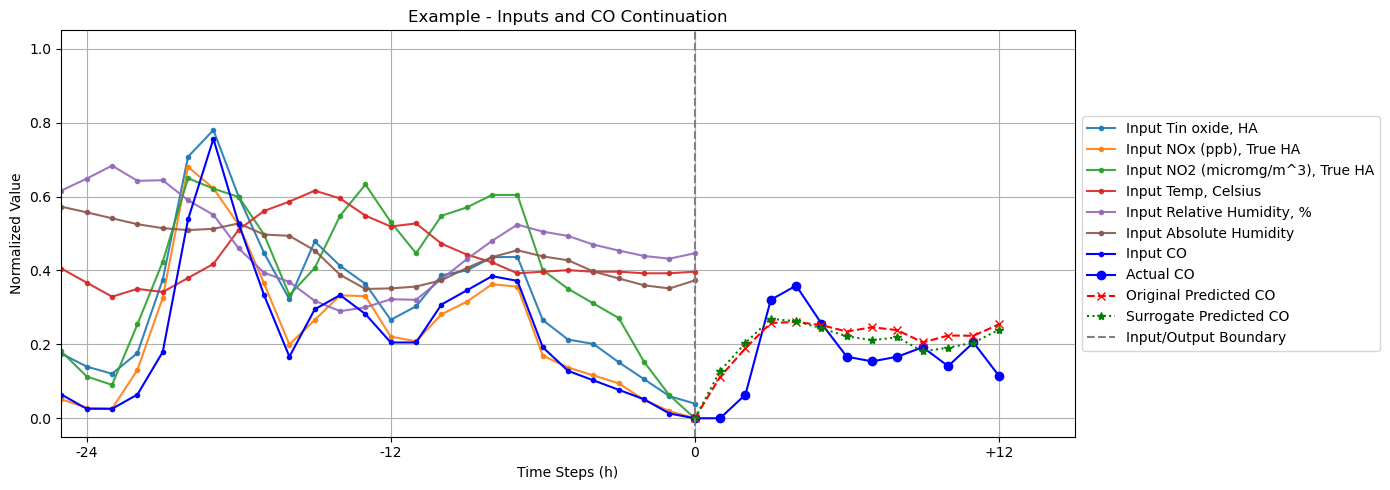

Sum of all SHAP values: 0.10297288052323791
Expected Value: 0.025020694
Sum of SHAP values + Expected Value: 0.1279935748833749
Surrogate Model Output: 0.12799357


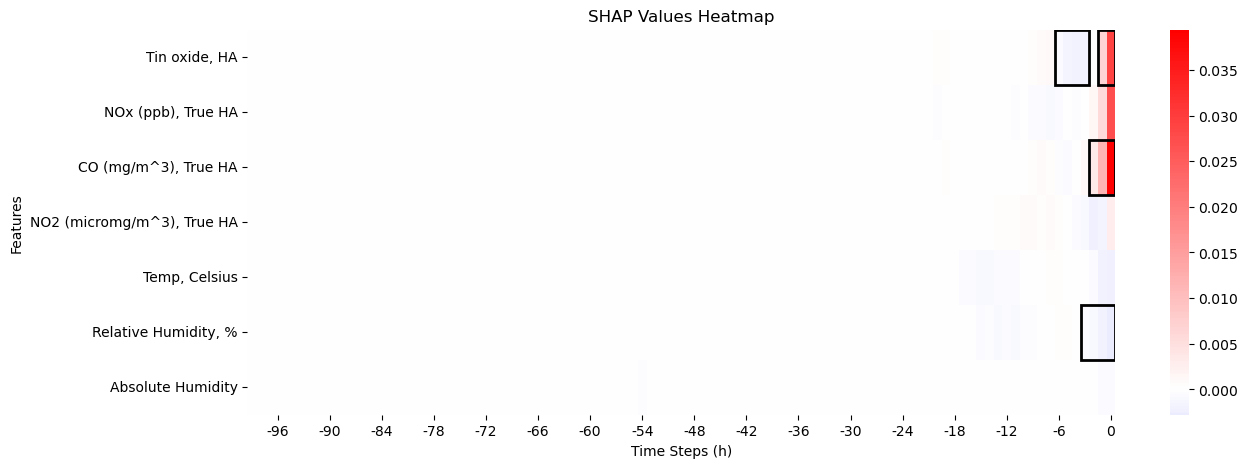

Most Positive Segments:
Segment 1:
  Variable: CO (mg/m^3), True HA
  Sum of SHAP values: 0.0547
  Start time step: -2
  End time step: 0
  Segment values: [0.051,0.013,0.   ]
  All time average: 0.378
  All time standard deviation: 0.204

Segment 2:
  Variable: Tin oxide, HA
  Sum of SHAP values: 0.0355
  Start time step: -1
  End time step: 0
  Segment values: [0.06,0.04]
  All time average: 0.368
  All time standard deviation: 0.203


Most Negative Segments:
Segment 1:
  Variable: Relative Humidity, %
  Sum of SHAP values: -0.00632
  Start time step: -3
  End time step: 0
  Segment values: [0.454,0.439,0.432,0.447]
  All time average: 0.377
  All time standard deviation: 0.198

Segment 2:
  Variable: Tin oxide, HA
  Sum of SHAP values: -0.0059
  Start time step: -6
  End time step: -3
  Segment values: [0.266,0.213,0.201,0.152]
  All time average: 0.368
  All time standard deviation: 0.203



In [502]:
# Example usage of plot_example (you can replace these with actual values)
plot_example(test_x[example_index], actual_output, predicted_og, predicted_surrogate, 'CO (mg/m^3), True HA', interest_cols)

t = 0

# Since the SHAP values shape is (12, 1, 700), we need to select the first output's SHAP values
shap_value = np.array(shap_values)[t]

# Reshape the SHAP values back to the original input shape
shap_value_reshaped = shap_value.reshape(test_x[example_index].shape)

# Print the sum of all SHAP values
print("Sum of all SHAP values:", shap_value_reshaped.sum())

# Calculate the expected value (mean of the model's output over the background dataset) for each time step
expected_value = np.mean(model_surrogate.predict(test_x, verbose=0), axis=0)[t][0]
print("Expected Value:", expected_value)

# Verify the relationship: sum of SHAP values + expected value should equal the model's prediction
shap_sum_with_expected = shap_value_reshaped.sum() + expected_value
print("Sum of SHAP values + Expected Value:", shap_sum_with_expected)

# Get the surrogate model's prediction for the selected example
print("Surrogate Model Output:", predictions_surrogate[example_index][t][0])

# Create a custom colormap with a more distinct white center
colors = [
    (0.0, "blue"),
    (0.5, "white"),
    (1.0, "red")
]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Plot SHAP values as a heat map
def plot_shap_heatmap(shap_values, feature_names, most_positive_segments=None, most_negative_segments=None):
    plt.figure(figsize=(14, 5))
    plt.title("SHAP Values Heatmap")
    sns.heatmap(shap_values.T, cmap=custom_cmap, center=0, yticklabels=feature_names, xticklabels=np.arange(shap_values.shape[0]))
    plt.xlabel("Time Steps (h)")
    plt.ylabel("Features")
    # Set the x-axis ticks and labels
    tick_positions = np.arange(shap_values.shape[0]-1, -1, -6)[::-1]
    labels = np.arange(-(len(tick_positions) - 1) * 6, 1, step=6)
    plt.xticks(tick_positions + 0.5, labels=labels, rotation='horizontal', ha='center')
    
    # Highlight most positive segments
    if most_positive_segments:
        for feature, start_idx, end_idx, _ in most_positive_segments:
            feature_idx = feature_names.index(feature)
            plt.gca().add_patch(
                plt.Rectangle((start_idx, feature_idx), end_idx - start_idx + 1, 1, fill=False, edgecolor='black', linewidth=2)
            )

    # Highlight most negative segments
    if most_negative_segments:
        for feature, start_idx, end_idx, _ in most_negative_segments:
            feature_idx = feature_names.index(feature)
            plt.gca().add_patch(
                plt.Rectangle((start_idx, feature_idx), end_idx - start_idx + 1, 1, fill=False, edgecolor='black', linewidth=2)
            )

    plt.show()

def find_extreme_segments(shap_values_reshaped, num_positive=1, num_negative=1, threshold_ratio=0.1, max_exceptions=1):
    num_features = shap_values_reshaped.shape[1]
    num_time_steps = shap_values_reshaped.shape[0]
    
    # Helper function to find the next most positive or most negative segment
    def find_next_segment(shap_values, find_positive=True):
        best_sum = float('-inf') if find_positive else float('inf')
        best_start_idx, best_end_idx, best_feature_idx = 0, 0, 0

        for feature_idx in range(num_features):
            for i in range(num_time_steps):
                current_sum = 0
                exceptions_count = 0
                values_in_segment = []

                for j in range(i, num_time_steps):
                    if (i, feature_idx) in used_indices or (j, feature_idx) in used_indices:
                        continue
                    current_value = shap_values[j, feature_idx]
                    current_sum += current_value
                    values_in_segment.append(current_value)
                    
                    max_value = max(values_in_segment)
                    min_value = min(values_in_segment)

                    if find_positive:
                        if min_value < threshold_ratio * max_value:
                            exceptions_count += 1
                        if exceptions_count > max_exceptions:
                            break
                    else:
                        if max_value > threshold_ratio * min_value:
                            exceptions_count += 1
                        if exceptions_count > max_exceptions:
                            break

                    if (find_positive and current_sum > best_sum) or (not find_positive and current_sum < best_sum):
                        best_sum = current_sum
                        best_start_idx = i
                        best_end_idx = j
                        best_feature_idx = feature_idx

        return best_feature_idx, best_start_idx, best_end_idx, best_sum

    # Store segments
    most_positive_segments = []
    most_negative_segments = []
    used_indices = set()

    # Find most positive segments
    for _ in range(num_positive):
        feature_idx, start_idx, end_idx, segment_sum = find_next_segment(shap_values_reshaped, find_positive=True)
        if segment_sum > 0:  # Ensure most positive segment sum is positive
            most_positive_segments.append((interest_cols[feature_idx], start_idx, end_idx, segment_sum))
            used_indices.update((i, feature_idx) for i in range(start_idx, end_idx + 1))

    # Find most negative segments
    for _ in range(num_negative):
        feature_idx, start_idx, end_idx, segment_sum = find_next_segment(shap_values_reshaped, find_positive=False)
        if segment_sum < 0:  # Ensure most negative segment sum is negative
            most_negative_segments.append((interest_cols[feature_idx], start_idx, end_idx, segment_sum))
            used_indices.update((i, feature_idx) for i in range(start_idx, end_idx + 1))

    return most_positive_segments, most_negative_segments

# Calculate and print statistics for the segments
def print_segment_stats(segments, test_x, full_test_x, title):
    print(title)
    for i, (feature, start_idx, end_idx, segment_sum) in enumerate(segments, 1):
        feature_idx = interest_cols.index(feature)
        segment_values = test_x[start_idx:end_idx + 1, feature_idx]
        full_avg = np.mean(full_test_x[:, feature_idx])
        full_std = np.std(full_test_x[:, feature_idx])
        print(f"Segment {i}:")
        print(f"  Variable: {feature}")
        print(f"  Sum of SHAP values: {segment_sum:.3g}")
        print(f"  Start time step: {start_idx-shap_value_reshaped.shape[0]+1}")
        print(f"  End time step: {end_idx-shap_value_reshaped.shape[0]+1}")
        print(f"  Segment values: {np.array2string(segment_values, precision=3, separator=',')}")
        print(f"  All time average: {full_avg:.3g}")
        print(f"  All time standard deviation: {full_std:.3g}")
        print()

# Inputs to determine the number of most positive and most negative segments
num_most_positive_segments = 2
num_most_negative_segments = 2
threshold_ratio = 0.1  # 10%
max_exceptions = 1  # Allow 1 exception

# Calculate the most positive and most negative sum of SHAP values across all input variables
most_positive_segments, most_negative_segments = find_extreme_segments(shap_value_reshaped.copy(), num_most_positive_segments, num_most_negative_segments, threshold_ratio, max_exceptions)

# Plot the SHAP heatmap with marked segments
plot_shap_heatmap(shap_value_reshaped, interest_cols, most_positive_segments, most_negative_segments)

# Print the results for most positive segments
print_segment_stats(most_positive_segments, test_x[example_index], test_x, "Most Positive Segments:")

# Print the results for most negative segments
print_segment_stats(most_negative_segments, test_x[example_index], test_x, "\nMost Negative Segments:")


## Prompt creation

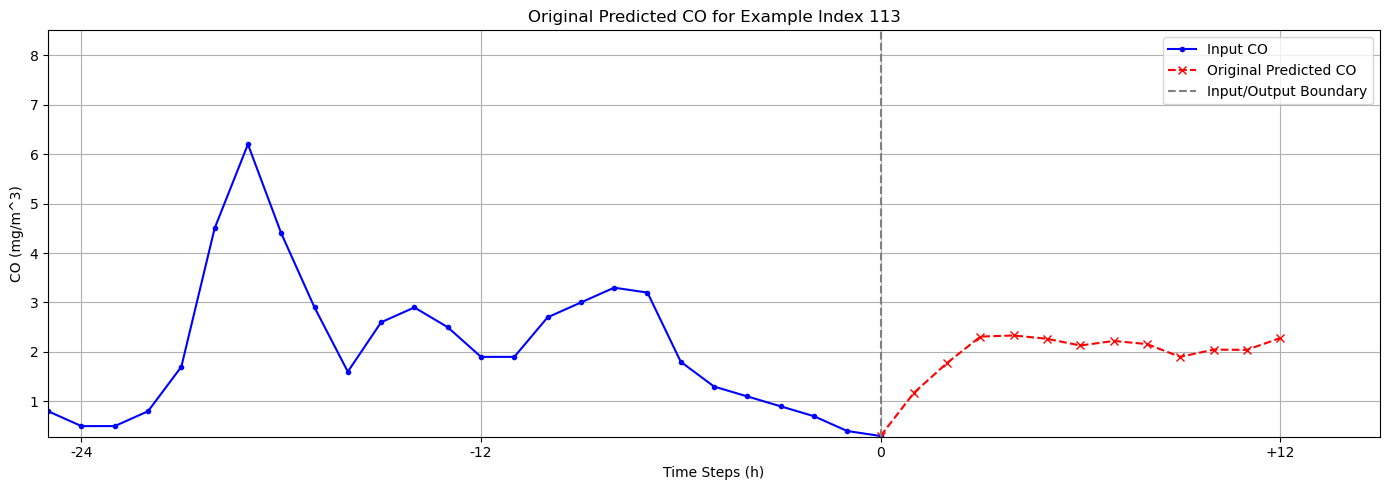

Last input CO value: 0.3
Predicted CO values: [1.17, 1.78, 2.31, 2.33, 2.27, 2.13, 2.22, 2.16, 1.9, 2.05, 2.04, 2.28]
Differences: [0.87, 0.61, 0.53, 0.02, -0.06, -0.14, 0.09, -0.06, -0.26, 0.15, -0.01, 0.24]


In [504]:
def plot_original_predicted_co(inputs, predicted_og, feature_name, all_features, example_index, scaler):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
        
        input_time_steps = np.arange(-inputs.shape[0] + 1, 1)
        future_time_steps = np.arange(1, len(predicted_og) + 1)

        plt.figure(figsize=(14, 5))

        # Plot the input CO feature
        input_co_normalized = inputs[:, all_features.index(feature_name)]
        input_co_original = scaler.inverse_transform(inputs)[:, all_features.index(feature_name)]
        plt.plot(input_time_steps, input_co_original, label='Input CO', color='blue', marker='.')

        # Plot the last point of input CO to ensure visual continuity
        last_input_value_original = input_co_original[-1]

        # Inverse transform the predicted values to original scale
        last_input_expanded = np.repeat(inputs[-1, :].reshape(1, -1), len(predicted_og), axis=0)
        last_input_expanded[:, all_features.index(feature_name)] = predicted_og
        
        predicted_og_original = scaler.inverse_transform(last_input_expanded)[:, all_features.index(feature_name)]
        
        # Plot original predicted CO from the last input CO point
        plt.plot([0] + list(future_time_steps), [last_input_value_original] + list(predicted_og_original), label='Original Predicted CO', color='red', linestyle='--', marker='x')

        # Draw a vertical line to indicate the transition from input to output
        plt.axvline(x=0, color='grey', linestyle='--', label='Input/Output Boundary')

        plt.title(f'Original Predicted CO for Example Index {example_index}')
        plt.xlabel('Time Steps (h)')
        plt.ylabel('CO (mg/m^3)')

        # Set ticks every 12 hours, ensuring they go through zero
        max_time_steps = max(inputs.shape[0], len(predicted_og))
        all_ticks = np.arange(-((inputs.shape[0] // 12) * 12), (len(predicted_og) + 12), 12)
        plt.xticks(all_ticks)

        # Customizing tick labels to include explicit '+' for positive values, excluding zero
        tick_labels = [f'{tick:+d}' if tick != 0 else '0' for tick in all_ticks]
        plt.gca().set_xticklabels(tick_labels)

        # Set y-axis limits based on the original scale of the CO values
        co_min, co_max = scaler.data_min_[all_features.index(feature_name)], scaler.data_max_[all_features.index(feature_name)]
        plt.ylim(co_min * 0.95, co_max * 1.05)
        plt.xlim(-25, 15)

        # Moving the legend outside of the plot to the right
        plt.legend()

        plt.grid(True)
        plt.tight_layout()  # Adjust layout to make room for the legend
        plt.show()

    return last_input_value_original, predicted_og_original

# Assuming the index of 'CO (mg/m^3), True HA' in the feature list
co_index = interest_cols.index('CO (mg/m^3), True HA')

# Get the surrogate model's prediction for the selected example
predicted_og = modelAQ.predict(test_x[[example_index]], verbose=0).flatten()

# Plot original predicted CO starting from the last input CO value
last_input_value_original, predicted_og_original = plot_original_predicted_co(test_x[example_index], predicted_og, 'CO (mg/m^3), True HA', interest_cols, example_index, min_max_scaler)

rounded_predicted_og_original = [float(f'{num:.3g}') for num in predicted_og_original]

# Print the last input time step and the predicted CO values
print(f'Last input CO value: {float(f"{last_input_value_original:.3g}")}')
print(f'Predicted CO values: {rounded_predicted_og_original}')

# Calculate and print the differences from the previous value, including the first difference
differences = [rounded_predicted_og_original[0] - float(f'{last_input_value_original:.3g}')] + \
              [rounded_predicted_og_original[i] - rounded_predicted_og_original[i - 1] for i in range(1, len(rounded_predicted_og_original))]
rounded_differences = [float(f'{num:.3g}') for num in differences]
print(f'Differences: {rounded_differences}')


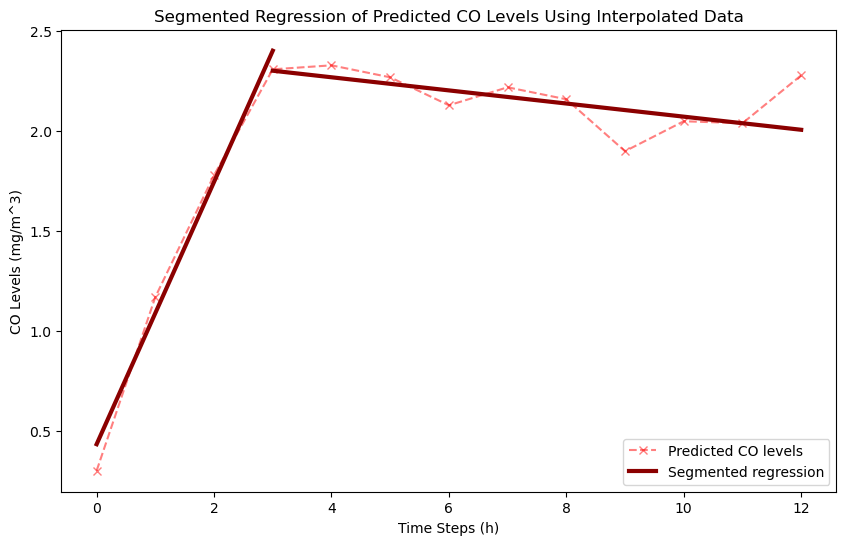

Individual Segment Details:
Segment from 0 to 3: Values [0.3  1.17 1.78 2.31], Slope 0.6568, Status: rising
Segment from 3 to 12: Values [2.31 2.33 2.27 2.13 2.22 2.16 1.9  2.05 2.04 2.28], Slope -0.0329, Status: constant

Combined Segment Details:
Rising segment from 0 to 3
Declining segment from 3 to 12


In [505]:
# Original Predicted CO values
original_predicted_co = np.array([last_input_value_original]+rounded_predicted_og_original)
original_time_steps = np.arange(len(original_predicted_co))

# Interpolate the data to create a denser dataset
def interpolate_data(x, y, num_points):
    new_x = np.linspace(x.min(), x.max(), num_points * (len(x) - 1) + 1)
    new_y = np.interp(new_x, x, y)
    return new_x, new_y

interpolated_time_steps, interpolated_predicted_co = interpolate_data(original_time_steps, original_predicted_co, 100)

# Perform piecewise linear regression
def piecewise_linear_fit(x, y, original_x, max_segments, penalty_factor):
    best_aic = float('inf')
    best_model = None
    original_indices = [np.where(x == ox)[0][0] for ox in original_x]  # include all original data points
    for num_segments in range(1, max_segments + 1):
        for breakpoints in combinations(original_indices[1:-1], num_segments - 1):  # exclude first and last points for breakpoints
            segments = [original_indices[0]] + list(breakpoints) + [original_indices[-1]]
            models = []
            total_mse = 0
            for i in range(len(segments) - 1):
                start, end = segments[i], segments[i + 1]
                model = LinearRegression().fit(x[start:end+1].reshape(-1, 1), y[start:end+1])
                mse = mean_squared_error(y[start:end+1], model.predict(x[start:end+1].reshape(-1, 1)))
                total_mse += mse * (end - start + 1)
                models.append((model, start, end))
            aic = len(y) * np.log(total_mse / len(y)) + penalty_factor * num_segments * 2
            if aic < best_aic:
                best_aic = aic
                best_model = models
    return best_model

# Plotting function to use only original data
def plot_segments(x, y, models):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, color='red', linestyle='--', marker='x', label='Predicted CO levels', alpha=0.5)
    for model, start, end in models:
        x_range = interpolated_time_steps[start:end+1]
        y_range = model.predict(x_range.reshape(-1, 1))
        plt.plot(x_range, y_range, color='darkred', linewidth=3, label='Segmented regression' if start == models[0][1] else "")
    plt.xlabel('Time Steps (h)')
    plt.ylabel('CO Levels (mg/m^3)')
    plt.title('Segmented Regression of Predicted CO Levels Using Interpolated Data')
    plt.legend()
    plt.show()

    # Print individual segment details
    print("Individual Segment Details:")
    for model, start, end in models:
        slope = model.coef_[0]
        status = "rising" if slope > 0.05 else "declining" if slope < -0.05 else "constant"
        original_segment = original_predicted_co[(start // 100):(end // 100 + 1)]
        print(f"Segment from {start // 100} to {end // 100}: Values {original_segment}, Slope {slope:.4f}, Status: {status}")

    # Print combined segment details
    print("\nCombined Segment Details:")
    combined_segments = []
    last_status = None
    for model, start, end in models:
        slope = model.coef_[0]
        status = "rising" if slope > 0.03 else "declining" if slope < -0.03 else "constant"
        if status == last_status:
            combined_segments[-1][2] = end // 100  # update the end of the last segment
        else:
            combined_segments.append([status, start // 100, end // 100])
            last_status = status
    for status, start, end in combined_segments:
        print(f"{status.capitalize()} segment from {start} to {end}")

# Parameters
max_segments = 4
penalty_factor = 700  # Adjust the penalty for more or fewer segments

# Fit the model using the interpolated data
best_model = piecewise_linear_fit(interpolated_time_steps.reshape(-1, 1), interpolated_predicted_co, original_time_steps, max_segments, penalty_factor)

# Plot using only the original data and the segments found
plot_segments(original_time_steps, original_predicted_co, best_model)


Segment surrogate prediction:  -0.029658254
Expected value segment:  -0.04543984
Sum of segment SHAP values:  0.015781583855035322
SHAP + expected value:  -0.029658255508062822


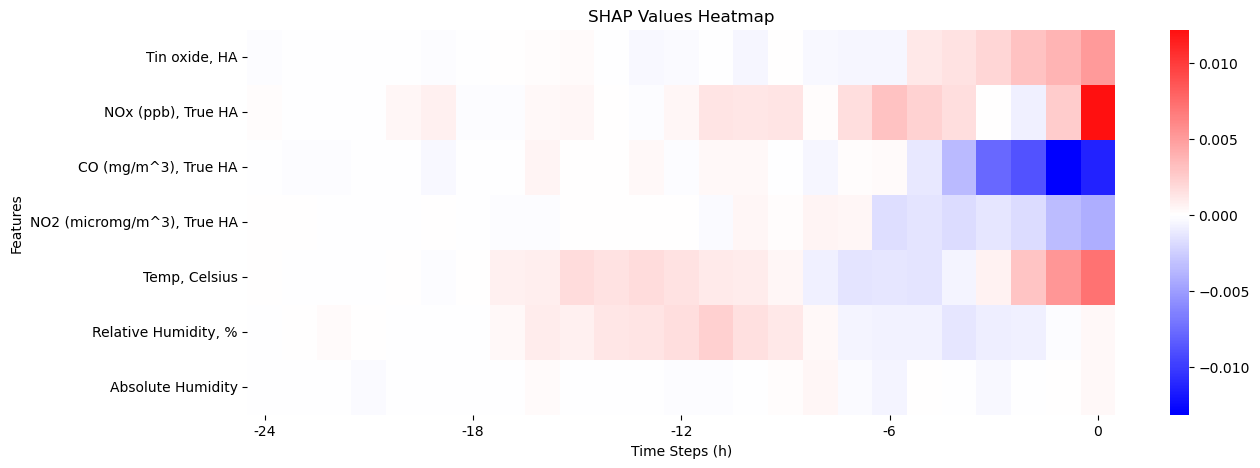

Most Positive Segments:
Segment 1:
  Variable: Tin oxide, HA
  Sum of SHAP values: 0.0167
  Start time step: -5
  End time step: 0
  Segment values: [0.213,0.201,0.152,0.106,0.06 ,0.04 ]
  All time average: 0.368
  All time standard deviation: 0.203


Most Negative Segments:
Segment 1:
  Variable: CO (mg/m^3), True HA
  Sum of SHAP values: -0.0446
  Start time step: -4
  End time step: 0
  Segment values: [0.103,0.077,0.051,0.013,0.   ]
  All time average: 0.378
  All time standard deviation: 0.204



In [508]:
s = 1 #segment

# Function to sum SHAP values per segment
def sum_per_segment(shap_values, example_index, predictions_surrogate, segments):
    summed_shap_values = []
    summed_predictions_surrogate = []
    summed_expected_value = []

    for _, start, end in segments:
        # Convert start and end indices from interpolated indices to original indices
        original_start = start // 100
        original_end = end // 100

        # Python slicing does not include the endpoint
        segment_shap_values = shap_values[original_start:original_end]
        segment_predictions_surrogate = predictions_surrogate[example_index][original_start:original_end]
        segment_expected_value = np.mean(model_surrogate.predict(test_x, verbose=0), axis=0)[original_start:original_end]
        
        # Sum the SHAP values and surogate prediction along the time dimension
        summed_segment_shap = np.sum(segment_shap_values, axis=0)
        summed_segment_surrogate = np.sum(segment_predictions_surrogate, axis=0)
        summed_segment_expected_value = np.sum(segment_expected_value)
        
        summed_shap_values.append(summed_segment_shap)
        summed_predictions_surrogate.append(summed_segment_surrogate)
        summed_expected_value.append(summed_segment_expected_value)
        
    return np.array(summed_shap_values), np.array(summed_predictions_surrogate), np.array(summed_expected_value)

# Call the function with the SHAP values and the segment data
summed_shap_values, summed_prediction_surrogate, summed_expected_value = sum_per_segment(shap_values, example_index, predictions_surrogate, best_model)

summed_shap_value = np.array(summed_shap_values)[s]

# Reshape the SHAP values back to the original input shape
summed_shap_value_reshaped = summed_shap_value.reshape(test_x[example_index].shape)

print("Segment surrogate prediction: ", summed_prediction_surrogate[s][0])
print("Expected value segment: ", summed_expected_value[s])
print("Sum of segment SHAP values: ", summed_shap_value_reshaped.sum())
print("SHAP + expected value: ", summed_expected_value[s] + summed_shap_value_reshaped.sum())

slope = best_model[s][0].coef_[0]

# Inputs to determine the number of most positive and most negative segments
num_most_positive_segments = 2 if slope > 0.05 else 0 if slope < -0.05 else 1
num_most_negative_segments = 0 if slope > 0.05 else 2 if slope < -0.05 else 1
threshold_ratio = 0.1  # 10%
max_exceptions = 1  # Allow 1 exception

# Calculate the most positive and most negative sum of SHAP values across all input variables
most_positive_segments, most_negative_segments = find_extreme_segments(summed_shap_value_reshaped.copy(), num_most_positive_segments, num_most_negative_segments, threshold_ratio, max_exceptions)

# Plot the SHAP heatmap with marked segments
plot_shap_heatmap(summed_shap_value_reshaped, interest_cols, most_positive_segments, most_negative_segments)

# Print the results for most positive segments
print_segment_stats(most_positive_segments, test_x[example_index], test_x, "Most Positive Segments:")

# Print the results for most negative segments
print_segment_stats(most_negative_segments, test_x[example_index], test_x, "\nMost Negative Segments:")


### *GPT4*

In [507]:
print("""
A time series forecasting model was trained on a multivariate time series dataset and your task is to create a convincing story that explains the predictions to laymen, who you can assume, have no technical background, but they like numbers. To do this you'll have to complete multiple intermediary steps, but first some background knowledge:

The dataset contains hourly averaged responses from a metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level, within an Italian city. Ground Truth hourly averaged concentrations for CO, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2)  were provided by a co-located reference certified analyzer.

The dataset contains 7 variables:
- NOx (ppb), True HA: True hourly averaged NOx concentration in ppb
- Tin oxide, HA: PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
- CO (mg/m^3), True HA: True hourly averaged concentration CO in mg/m^3
- NO2 (micromg/m^3), True HA: True hourly averaged NO2 concentration in microg/m^3
- Temp, Celsius: Temperature in Celcius
- Relative Humidity, %: Relative Humidity
- Absolute Humidity: Absolute Humidity

The model used was an LSTM and was tasked to predict a series of the CO levels of 12 consecutive hours (timestep +1h through +12h) based on the levels of the variables mentioned above during the 100 previous hours (timestep -99h through 0h). 
The prediction of the model that you have to explain is as follows. 
""")
print(f'Last input CO value: {float(f"{last_input_value_original:.3g}")}')
print(f'Predicted CO values: {rounded_predicted_og_original}')
print("""
This prediction was classified by a piecewise regression model into the following segments:
""")
i = 0
for model, start, end in best_model:
    i += 1
    slope = model.coef_[0]
    status = "rising" if slope > 0.05 else "declining" if slope < -0.05 else "constant"
    original_segment = original_predicted_co[(start // 100):(end // 100 + 1)]
    if start==0:
        print(f"Prediction segment {i} from timestep {start // 100}h to +{end // 100}h: Values {original_segment}, Slope {slope:.4f}, Status: {status}")
    else:
        print(f"Prediction segment {i} from timestep +{start // 100}h to +{end // 100}h: Values {original_segment}, Slope {slope:.4f}, Status: {status}")

print("""
Your first task is to describe the evolution of the predicted CO values in one sentence using some numbers. Mention the big evolution(s), trends, or non-evolution(s), don’t bother with small fluctuations. Coordinate your description with the segmentation but don’t mention them explicitly, and make your description more nuanced, capture more detail than the segments like declines even faster, or flattens out, …

As second and biggest step you need to create an explanation for each of these prediction segments on why they are either rising, declining or staying constant using some numbers. To do this we already determined which input segments were attributed the biggest share of the prediction (using SHAP). In the tables below you’ll find for each prediction segments which input segments were the highest contributors to the prediction of how CO was predicted to change. Attribution of change in CO directly corresponds to how much the prediction changed because of this segment. For each of the prediction segments create a description of the influence of the input segments, in which you mention what the input segments are doing and when, that might have caused the rise, decline, or staying constant (for this last one you might mention two effects canceling each other). Start by summarizing, for each input segment, the following 3 aspects: evolution of the input segment values, comparison to all time average, and time before the prediction segment. Then combine to write one explanation using numbers.
""")

# Get the scaling factor for CO
co_index = interest_cols.index('CO (mg/m^3), True HA')
co_scale = min_max_scaler.scale_[co_index]

# Number of timesteps
num_segments = len(summed_shap_values)

print("\n" + "-"*50 + "\n")

for s in range(num_segments):
    print(f"Prediction segment {s+1}:")
    
    original_start = int(best_model[s][1]/100)
    original_end = int(best_model[s][2]/100)
    diff = sum(rounded_differences[original_start:original_end])
    co_s_start = last_input_value_original if s==0 else rounded_predicted_og_original[original_start-1]
    co_s_end = rounded_predicted_og_original[original_end-1]

    slope = best_model[s][0].coef_[0]
    status = "rising" if slope > 0.05 else "declining" if slope < -0.05 else "remaining steady"
    plus_sign = "" if s==0 else "+"
    if status == "remaining steady":
        steady_state = np.mean(np.append(rounded_predicted_og_original[0:original_end],last_input_value_original)) if s==0 else np.mean(rounded_predicted_og_original[original_start-1:original_end])
        print(f"\nThe main reason(s) for the predicted CO level {status} around {steady_state:.3g} mg/m^3 from timestep {plus_sign}{original_start}h to +{original_end}h")
    else:
        print(f"\nThe main reason(s) for the predicted CO level {status} by {diff:.3g} mg/m^3 from timestep {plus_sign}{original_start}h to +{original_end}h")

    # Since the SHAP values shape is (s, 1, 700), we need to select the SHAP values of segment s
    summed_shap_value = np.array(summed_shap_values)[s]

    # Reshape the SHAP values back to the original input shape
    summed_shap_value_reshaped = summed_shap_value.reshape(test_x[example_index].shape)

    # Inputs to determine the number of most positive and most negative segments
    slope = best_model[s][0].coef_[0]
    
    # Inputs to determine the number of most positive and most negative segments
    num_most_positive_segments = 2 if slope > 0.05 else 0 if slope < -0.05 else 1
    num_most_negative_segments = 0 if slope > 0.05 else 2 if slope < -0.05 else 1
    threshold_ratio = 0.1  # 10%
    max_exceptions = 1  # Allow 1 exception

    # Calculate the most positive and most negative sum of SHAP values across all input variables
    most_positive_segments, most_negative_segments = find_extreme_segments(summed_shap_value_reshaped.copy(), num_most_positive_segments, num_most_negative_segments, threshold_ratio, max_exceptions)

    # Print the results for most positive segments
    for negative, most_extreme_segments in enumerate([most_positive_segments, most_negative_segments], 0):
        if most_extreme_segments:
            if negative:
                print(f"\nMost negative attribution(s):")
            else:
                print(f"\nMost positive attribution(s):")
        for i, (feature, start_idx, end_idx, segment_sum) in enumerate(most_extreme_segments, 1):
            feature_idx = interest_cols.index(feature)
            segment_values = test_x[example_index][start_idx:end_idx + 1, feature_idx]
        
            # Rescale the segment values
            segment_values_original = min_max_scaler.inverse_transform(test_x[example_index].reshape(-1, len(interest_cols)))[:, feature_idx][start_idx:end_idx + 1]
            full_avg = np.mean(min_max_scaler.inverse_transform(test_x.reshape(-1, len(interest_cols)))[:, feature_idx])
            full_std = np.std(min_max_scaler.inverse_transform(test_x.reshape(-1, len(interest_cols)))[:, feature_idx])
        
            # Rescale the segment_sum
            segment_sum_original = segment_sum / co_scale

            print(f"  Input segment {i}:")
            print(f"    Variable: {feature}")
            print(f"    Attribution of change in CO: {segment_sum_original:.3g} mg/m^3")
            t_start = start_idx - shap_value_reshaped.shape[0] + 1
            print(f"    Start: {t_start}h")
            t_end = end_idx - shap_value_reshaped.shape[0] + 1
            print(f"    End: {t_end}h")
            status = "predicted rise in CO" if slope > 0.05 else "predicted decline in CO" if slope < -0.05 else "predicted constant CO segment"
            print(f"    Time before the {status} (on average): {(original_end + original_start)/2 - (t_start + t_end)/2}h")
            print(f"    Segment values: {segment_values_original}")
            print(f"    All time average: {full_avg:.3g}")
            print(f"    All time standard deviation: {full_std:.3g}")

    print("\n" + "-"*50 + "\n")

print("""
Now comes your final task, summarize everything into one paragraph, ready to be shown to users as the explanation for why this prediction was madel. To do this start by reiterating the description of the CO predictions, based on the one you made earlier. Then summarise the product from your previous task to end up with one coherent fact-based explanation. Remember that the users like to see a lot of numbers in your final explanation, they are especially interested in actual hours, so try to include these always. Also try and include extensive intuitions and write this final paragraph almost like a story. Use decisive language.
""")


A time series forecasting model was trained on a multivariate time series dataset and your task is to create a convincing story that explains the predictions to laymen, who you can assume, have no technical background, but they like numbers. To do this you'll have to complete multiple intermediary steps, but first some background knowledge:

The dataset contains hourly averaged responses from a metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level, within an Italian city. Ground Truth hourly averaged concentrations for CO, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2)  were provided by a co-located reference certified analyzer.

The dataset contains 7 variables:
- NOx (ppb), True HA: True hourly averaged NOx concentration in ppb
- Tin oxide, HA: PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
- CO (mg/m^3), True HA: True hourly average